# Retrieval Experiment

## Run Experiment

In [1]:
import pandas as pd
import numpy as np
import chromadb
import subprocess
import os
from langchain.document_loaders import DirectoryLoader
from langchain.document_loaders import UnstructuredPDFLoader
from langchain.vectorstores import Chroma
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.chains import RetrievalQA
from langchain.llms import LlamaCpp
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler
from langchain.prompts import PromptTemplate
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import CharacterTextSplitter
from langchain.chains.question_answering import load_qa_chain
from langchain.output_parsers import CommaSeparatedListOutputParser
from semantic_router.layer import RouteLayer
from langchain.chains import ConversationChain
from langchain.prompts import PromptTemplate
from langchain_core.prompts.prompt import PromptTemplate
from langchain.docstore.document import Document
from langchain_chroma import Chroma
from langchain_community.document_loaders import TextLoader
from langchain_community.embeddings.sentence_transformer import (
    SentenceTransformerEmbeddings,
)
from langchain_text_splitters import CharacterTextSplitter


#BERTscore
import bert_score
import logging
import transformers
transformers.tokenization_utils.logger.setLevel(logging.ERROR)
transformers.configuration_utils.logger.setLevel(logging.ERROR)
transformers.modeling_utils.logger.setLevel(logging.ERROR)
from bert_score import BERTScorer
from BRAD import brad
from BRAD import rag

[nltk_data] Downloading package words to /home/jpic/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jpic/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jpic/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
help(brad.load_literature_db)

Help on function load_literature_db in module BRAD.brad:

load_literature_db(persist_directory='/nfs/turbo/umms-indikar/shared/projects/RAG/databases/Transcription-Factors-5-10-2024/')
    Loads a literature database using specified embedding model and settings.
    
    :param persist_directory: The directory where the database is stored, defaults to "/nfs/turbo/umms-indikar/shared/projects/RAG/databases/Transcription-Factors-5-10-2024/"
    :type persist_directory: str, optional
    
    :raises FileNotFoundError: If the specified directory does not exist or is inaccessible.
    :raises Warning: If the loaded database contains no articles.
    
    :return: A tuple containing the vector database and the embeddings model.
    :rtype: tuple



In [3]:
vectordb, embeddings_model = brad.load_literature_db(persist_directory='/nfs/turbo/umms-indikar/shared/projects/RAG/databases/EXP2/')

Sun Jun  9 12:53:44 2024 INFO Use pytorch device_name: cpu
Sun Jun  9 12:53:44 2024 INFO Load pretrained SentenceTransformer: BAAI/bge-base-en-v1.5
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Sun Jun  9 12:54:07 2024 INFO Anonymized telemetry enabled. See                     https://docs.trychroma.com/telemetry for more information.
Sun Jun  9 12:54:09 2024 INFO Collection DB_cosine_cSize_700_cOver_200 is not created.


In [4]:
prompts = [
    'What transcription factors are involved in cell reprogramming of skeletal muscle?',
    'What transcription factors are involved in cell reprogramming of stem cells?',
    'What are the differences between direct lineage reprogramming and induced pluripotency?',
    'What are the potential applications of cell reprogramming in regenerative medicine?',
    'How do transcription factors influence epigenetic modifications during the reprogramming process?',
    'What are the main challenges and limitations of using transcription factor-mediated reprogramming for therapeutic purposes?',
    'Can transcription factors alone efficiently reprogram cells, or are additional factors or conditions required for successful reprogramming?',
    'What role do non-coding RNAs play in transcription factor-mediated cell reprogramming?',
    'What are the current methods for delivering transcription factors to cells for reprogramming purposes?',
    'How does the overexpression or suppression of specific transcription factors affect the stability and functionality of reprogrammed cells?',
    'What are master regulators?',
    'How are pioneer factors different from master regulators?',
    'Are all transcription factors master regulators?',
    'What proportion of genes are transcription factors?',
    'What is cellular reprogramming and how is it achieved?',
    'What are the potential applications of cellular reprogramming in medicine?',
    'How do transcription factors regulate gene expression?',
    'What are the main types of transcription factors and how do they function?',
    'How do transcription factors influence cellular differentiation?',
    'What role do transcription factors play in cellular reprogramming?',
    'How are transcription factors used in induced pluripotent stem cell (iPSC) generation?',
    'What are the key differences between transcription factors and other regulators of gene expression?',
    'What is the cell cycle and what are its phases?',
    'How is the cell cycle regulated at the molecular level?',
    'How do transcription factors control progression through the cell cycle?',
    'How do different cell cycle phases contribute to cellular reprogramming?',
    'What are the implications of cell cycle dysregulation in disease?',
    'How are transcription factors involved in maintaining cell cycle integrity?',
    'How do transcription factors interact with cyclins and cyclin-dependent kinases?',
    'What are the key checkpoints in the cell cycle and how do they function?',
    'How does the expression of transcription factors change across different phases of the cell cycle?',
    'What role do transcription factors play in cell fate determination during the cell cycle?',
    'How does cellular reprogramming affect the cell cycle of reprogrammed cells?',
    'How can transcription factors be targeted to regulate the cell cycle in cancer therapy?',
    'What are the ethical considerations of using transcription factors in cellular reprogramming?',
    'How do cellular reprogramming and transcription factor therapy compare as potential treatments for diseases?',
    'How does epigenetic regulation influence transcription factor activity during the cell cycle?',
    'How are transcription factors identified and validated as regulators of the cell cycle?',
    'What are the challenges and future directions for research in cellular reprogramming and transcription factor biology?',
    'What techniques are used to identify transcription factor binding motifs?',
    'What is a transcription factor binding motif?',
    'Where does myod bind?',
    'What are the targets and first order interactions of MYOD?',
    'Who performed the first cell reprogramming experiment?',
    'Which cell types are common precursors in cell reprogramming?',
    'Explain the problem of identifying transcription factors in terms of control',
    'Explain the problem of identifying transcription factors in terms of machine learning ',
    'How does the Human TFome library enhance our understanding of cell differentiation compared to previous transcription factor libraries and approaches?',
    'Can you describe an experimental setup and screening process used to identify TFs that can induce differentiation in hPSCs without external soluble or biomechanical cues?',
    'What criteria and or methodologies were used to determine the TFs that induce differentiation in human pluripotent stem cells (hPSCs) within 4 days?',
    'What are the potential applications of the cell-autonomous programming approach in regenerative medicine and tissue engineering?',
    'How did the researchers validate that the differentiated cells (neurons, fibroblasts, oligodendrocytes, and vascular endothelial-like cells) exhibit molecular and functional similarities to primary cells?',
    'What is the primary challenge with transcription factor overexpression-based methods for generating cell types in vitro, and how does the new computer-guided design tool address this issue?',
    'Can you explain the role and mechanism of the IRENE computational framework in prioritizing instructive factors (IFs) for cellular conversions?',
    'How does the transposon-based genomic integration system enhance the efficiency of delivering instructive factors compared to other delivery methods?',
    'What specific metrics or criteria does IRENE use to maximize the agreement of the transcriptional and epigenetic landscapes between converted and target cells?',
    'How did the use of IRENE impact the efficiency of existing iPSC-differentiation protocols for natural killer cells and melanocytes?',
    'What experimental validations were performed to confirm the high efficiency of the new iPSC-derived mammary epithelial cell protocol established using IRENE?',
    'In what ways can computational approaches like IRENE complement traditional experimental methods in the field of cellular conversion and differentiation?',
    'What potential applications could the increased efficiency of iPSC-differentiation protocols have in clinical settings, such as cell transplantation therapies or disease modeling?',
    'How does the stochastic gene regulatory network model employed by IRENE differ from deterministic models, and what advantages does it offer in predicting efficient instructive factors?',
    'What future developments or improvements do the researchers anticipate for the IRENE tool and its applications in cell conversion technologies?',
    'What is the significance of MyoD as a master regulatory gene for myogenesis, and how does it influence muscle differentiation?',
    'How does the use of a retroviral long terminal repeat enhance the expression of MyoD in various differentiated cell types?',
    'What methodologies were employed to introduce MyoD into differentiated cell types, and what are the comparative advantages of using a DNA transfection vector versus a retrovirus?',
    'In what ways did the expression of MyoD lead to the activation of muscle-specific proteins in primary fibroblasts and differentiated cell lines from chicken, human, and rat?',
    "How did MyoD expression affect differentiated cell lines such as melanoma, neuroblastoma, liver, and adipocyte cells, and what does this reveal about MyoD's versatility?",
    'What evidence supports the conclusion that MyoD alone is sufficient to activate the downstream program for terminal muscle differentiation in various cell types?',
    "How do the findings regarding MyoD's ability to activate muscle genes in different cell lines challenge the current understanding of tissue-specific factors in muscle differentiation?",
    'What potential mechanisms might explain how MyoD activates other tissue-specific factors, if such factors are necessary for muscle differentiation?',
    'What implications do these findings have for the development of gene therapies or regenerative medicine approaches targeting muscle-related diseases?',
    'How might future research build on these findings to further elucidate the role of MyoD and other potential factors in muscle differentiation and cell reprogramming?',
    'What is the significance of the correlation between the intranuclear position of genes and their activity state in the context of gene expression regulation?',
    "How do 'transcription factories' function, and what is their role in nascent RNA production and RNA polymerase II activity?",
    'What methodologies were used to demonstrate that distal genes colocalize to the same transcription factory at high frequencies during transcription in vivo?',
    'How do shared nuclear subcompartments influence the dynamic organization and activity of active genes?',
    'What mechanisms might explain the migration of active genes into or out of transcription factories and its impact on transcription activation or abatement?',
    'How does the concept of genes migrating to preassembled transcription sites challenge the traditional understanding of transcription complex recruitment and assembly?',
    'What implications do these findings have for our understanding of nuclear organization and its role in gene regulation?',
    'What experimental evidence supports the idea that multiple genes can occupy the same transcription factory, and what challenges remain in directly observing this phenomenon?',
    'How might the findings about gene colocalization in transcription factories influence future research on gene expression and nuclear architecture?',
    'What potential applications could arise from understanding the dynamics of gene movement into and out of transcription factories in terms of disease treatment or genetic engineering?',
    'What are the key advances in cell fate manipulation and induction of pluripotency over the past decade?',
    'What technical aspects make the generation of induced pluripotent stem cells (iPSCs) relatively simple?',
    'What roles do the transcription factors OCT3/4, SOX2, KLF4, and MYC (collectively referred to as OSKM) play in the reprogramming of host cells to iPSCs?',
    'What are some of the poorly understood mechanisms underlying transcription factor-mediated reprogramming?',
    'What recent mechanistic insights have been obtained regarding the process of reprogramming cells into iPSCs?',
    'How has the efficiency of iPSC generation techniques improved in recent years, and what methods contributed to these improvements?',
    'What are the potential applications of more efficient iPSC generation techniques in regenerative medicine?',
    'How can advances in iPSC technology contribute to disease modeling and drug discovery?',
    'What challenges remain in fully understanding and optimizing the transcription factor-mediated reprogramming process?',
    'How might future research build on recent insights to further enhance the applications and efficiency of iPSC technology?',
    'What roles do transcription factors and chromatin-mediated gene silencing play in the process of development?',
    'How can the mis-expression of master regulator transcription factors reverse or redirect development, and what implications does this have for cancer development?',
    'What is the function of the wing-specific Vestigial master regulator in the context of reprogramming the developing eye?',
    'How does the H3.3K27M oncohistone mutation inhibit histone H3K27 trimethylation, and what is the significance of this inhibition in gene silencing?',
    'What findings were observed when the H3.3K27M oncohistone mutation was expressed, and how did it affect eye-to-wing reprogramming?',
    'What is CUT&Tag chromatin profiling, and how was it used to analyze mutant tissues in this study?',
    'How does the reduction of H3K27me3 domains upon oncohistone production suggest the necessity of silencing previous developmental programs for effective transformation?',
    'In what ways do the Vestigial master regulator and H3.3K27M mutation synergize to stimulate overgrowth of eye tissue, and how does this phenotype resemble mutations in Polycomb silencing components?',
    'What insights did transcriptome profiling of elongating RNA Polymerase II provide regarding the mis-regulation of signaling factors and tissue overgrowth?',
    'What challenges have researchers faced in linking genomic alterations to the transcriptional identity of cancer cells, and how does this study aim to address them?',
    'How does the network-based approach used in this study facilitate the identification of master regulator (MR) proteins in cancer?',
    'What criteria and methods were used to identify the 407 master regulator proteins across the 20 cohorts from The Cancer Genome Atlas (TCGA)?',
    'How are the 112 transcriptionally distinct tumor subtypes defined and characterized in this study?',
    'What are master regulator block modules (MRBs), and how were the 24 pan-cancer MRBs identified and organized?',
    'In what ways do MRBs regulate key cancer hallmarks and influence patient outcomes across multiple cohorts?',
    'What insights were gained regarding the impact of somatic alterations on master regulator activity in individual cancer samples?',
    'How do genetic and pharmacological validation assays confirm the predicted effects of upstream mutations on downstream cellular identity and phenotype?',
    'What mechanisms were proposed for how genetic alterations lead to changes in transcriptional identity and non-oncogene dependencies?',
    'How can the co-analysis of mutational and gene expression profiles contribute to identifying elusive cancer subtypes and generating testable hypotheses for the mechanisms mediating genetic alterations?',
    'What is transdifferentiation, and why is it significant for regenerative medicine?',
    'What challenges currently limit the identification of key transcription factors for reprogramming cells?',
    'How does the predictive system Mogrify overcome the limitations of exhaustive experimental testing for cell conversion?',
    'What methods does Mogrify use to combine gene expression data with regulatory network information for predicting reprogramming factors?',
    'How comprehensive is the atlas of cellular reprogramming defined by Mogrify, and what does it include?',
    'In what ways has Mogrify successfully predicted transcription factors used in known transdifferentiations?',
    'What were the two new transdifferentiations validated by Mogrify, and how were they experimentally confirmed?',
    'How does Mogrify facilitate the generalization of reprogramming human cells, and what implications does this have for future research?',
    'What practical applications can arise from the systematic implementation of novel cell conversions predicted by Mogrify?',
    "How does making Mogrify's predictions available to the research community help advance the field of cell conversion?",
    'What role do Transcriptional Regulatory Networks (TRNs) play in maintaining tissue homeostasis and cellular function?',
    'How do newly introduced transcription factors (TFs) re-establish target cell TRNs during direct trans-differentiation?',
    'Why is it important to understand the protective role of TRNs in starting cell types, such as dermal fibroblasts, against cellular reprogramming?',
    'What methodology was used to identify TFs specific to maintaining the fibroblast state in this study?',
    'How did the systematic knockdown of 18 fibroblast-enriched TFs help build the Matrix-RNAi, and what did this expression matrix reveal?',
    'What are the implications of finding seven highly interconnected TFs in the context of fibroblast identity maintenance?',
    'How did the suppression of four out of seven TFs lead to the generation of lipid droplets and the induction of PPARG and CEBPA expression?',
    'What was the significance of the observation that negative control knockdown cells maintained their fibroblastic character under the same induction conditions?',
    'How did global gene expression analyses demonstrate the effectiveness of knockdown-induced adipocytes in expressing genes associated with lipid metabolism and suppressing fibroblast genes?',
    'What novel strategy does this study propose for inducing transgene-free trans-differentiations, and how does it highlight the vulnerability of donor cell TRNs?',
    'What defines pioneer factors, and what is their unique ability in the context of chromatin?',
    'How do pioneer factors contribute to the initiation of opening closed chromatin?',
    'What mechanisms maintain the stability of cell identity through the epigenome and chromatin accessibility to transcription factors?',
    'How do pioneer factors counter these stability mechanisms to implement new cell fates?',
    'What role do active-chromatin histone modifications play at enhancers, and how are they introduced by pioneer factors?',
    'Why are pioneer factors considered master regulators of enhancer activation, and what is their significance in cell fate decisions during development?',
    'How might pioneer factors be leveraged for therapeutic applications in cellular reprogramming?',
    'What are the potential pathological consequences of pioneer factor misexpression, particularly in cancer?',
    'How do pioneer factors influence cell fate specification, cellular reprogramming, and cancer, according to the Review?',
    'What role do transcription factors play in the formation and maintenance of different cell types during development?',
    'Why do transcription factors largely dissociate from chromosomes during mitosis, and what implications does this have for cellular reprogramming?',
    'What is meant by the term "mitotic ad,vantage" in the context of nuclear transfer and reprogramming?',
    'How does the rate of exchange of a transcription factor on its designated DNA-binding site contribute to understanding cellular reprogramming during mitosis?',
    'Why is the Xenopus oocyte proposed as an experimental system to analyze the duration of transcription factor binding to DNA?',
    'What specific characteristics of the Xenopus oocyte make it suitable for accurately determining the concentration and duration of transcription factor binding?',
    'How could the concentration and duration of transcription factor binding in Xenopus oocytes provide insights into the activation of genes necessary for cell lineage determination?',
    'What experimental methods might be employed in Xenopus oocytes to measure transcription factor concentration and duration of binding?',
    'How do concentration and time serve as key variables governing the action of transcription factors in activating lineage-determining genes?',
    'What are the potential implications of these findings for our understanding of transcriptional regulation and cell fate determination during development?',
]

In [5]:
numDocs = 10
outputs = {
    'prompt':[],
}
for i in range(numDocs):
    outputs['known' + str(i)] = []
    outputs['knownRef' + str(i)] = []
    outputs['knownScore' + str(i)] = []
for prompt in prompts:
    print(prompt)
    documentSearch = vectordb.similarity_search_with_relevance_scores(prompt, k=numDocs)
    docs, scores = rag.getDocumentSimilarity(documentSearch)
    outputs['prompt'].append(prompt)
    for j in range(numDocs):
        outputs['known' + str(j)].append(docs[j].page_content)
        outputs['knownRef' + str(j)].append(docs[j].metadata)
        outputs['knownScore' + str(j)].append(scores[j])

What transcription factors are involved in cell reprogramming of skeletal muscle?
What transcription factors are involved in cell reprogramming of stem cells?
What are the differences between direct lineage reprogramming and induced pluripotency?
What are the potential applications of cell reprogramming in regenerative medicine?
How do transcription factors influence epigenetic modifications during the reprogramming process?
What are the main challenges and limitations of using transcription factor-mediated reprogramming for therapeutic purposes?
Can transcription factors alone efficiently reprogram cells, or are additional factors or conditions required for successful reprogramming?
What role do non-coding RNAs play in transcription factor-mediated cell reprogramming?
What are the current methods for delivering transcription factors to cells for reprogramming purposes?
How does the overexpression or suppression of specific transcription factors affect the stability and functionality o

In [6]:
df = pd.DataFrame(outputs)
df

,prompt,known0,knownRef0,knownScore0,known1,knownRef1,knownScore1,known2,knownRef2,knownScore2,...,knownScore6,known7,knownRef7,knownScore7,known8,knownRef8,knownScore8,known9,knownRef9,knownScore9
0,What transcription factors are involved in cel...,with particu-\nlar emphasis on the role of epi...,"{'page': 0, 'source': '/nfs/turbo/umms-indikar...",0.814628,"skeletal muscle. Cell 140,\n554–566 .\nMikkels...","{'page': 15, 'source': '/nfs/turbo/umms-indika...",0.814224,Developmental Cell\nResource\nGenome-wide MyoD...,"{'page': 0, 'source': '/nfs/turbo/umms-indikar...",0.812754,...,0.794037,other aspects of skeletal muscle development a...,"{'page': 0, 'source': '/nfs/turbo/umms-indikar...",0.792719,these \nlandmark reports not only presented th...,"{'page': 0, 'source': '/nfs/turbo/umms-indikar...",0.792233,a single myoblast cDNA encoding the\ntranscrip...,"{'page': 0, 'source': '/nfs/turbo/umms-indikar...",0.792178
1,What transcription factors are involved in cel...,REVIEW\nPioneer transcription factors in cell\...,"{'page': 0, 'source': '/nfs/turbo/umms-indikar...",0.843624,of\nnew strategies to improve the functional m...,"{'page': 0, 'source': '/nfs/turbo/umms-indikar...",0.831749,reprogramming. iPSCs are promising for \nmany ...,"{'page': 1, 'source': '/nfs/turbo/umms-indikar...",0.825945,...,0.819242,"model. PLoS Comput. Biol. 14, e1006052 (2018)....","{'page': 10, 'source': '/nfs/turbo/umms-indika...",0.819071,".,13, 14.\nGuerrero-Ramirez,G.I. et al. (2018)...","{'page': 7, 'source': '/nfs/turbo/umms-indikar...",0.818862,as methods utilizing chemical compounds and\nm...,"{'page': 0, 'source': '/nfs/turbo/umms-indikar...",0.818693
2,What are the differences between direct lineag...,"J. Funct. Biomater. 2023 ,14, 21 2 of 29\nDire...","{'page': 1, 'source': '/nfs/turbo/umms-indikar...",0.827610,"pluripotent \nor multi potent state\n3, has b...","{'page': 0, 'source': '/nfs/turbo/umms-indikar...",0.815788,and takes several months. Direct reprogramming...,"{'page': 1, 'source': '/nfs/turbo/umms-indikar...",0.813209,...,0.800321,Cell Stem Cell\nReview\nDirect Lineage Reprogr...,"{'page': 0, 'source': '/nfs/turbo/umms-indikar...",0.799130,from a patient. Such approaches provide holist...,"{'page': 22, 'source': '/nfs/turbo/umms-indika...",0.796559,"applications of direct reprogramming, includ-i...","{'page': 14, 'source': '/nfs/turbo/umms-indika...",0.788385
3,What are the potential applications of cell re...,approach to cellular reprogramming.\nThe chall...,"{'page': 7, 'source': '/nfs/turbo/umms-indikar...",0.857331,and more complete transdifferentiatio n. In th...,"{'page': 0, 'source': '/nfs/turbo/umms-indikar...",0.852261,3]. This review will discuss the various\nmeth...,"{'page': 1, 'source': '/nfs/turbo/umms-indikar...",0.842922,...,0.839321,1 Introduction\nInduced pluripotent stem cells...,"{'page': 1, 'source': '/nfs/turbo/umms-indikar...",0.838531,share the common goal of making direct\nconver...,"{'page': 3, 'source': '/nfs/turbo/umms-indikar...",0.836792,advancing this technology towards applications...,"{'page': 0, 'source': '/nfs/turbo/umms-indikar...",0.834418
4,How do transcription factors influence epigene...,transduced and endogenously upregulated tran-s...,"{'page': 16, 'source': '/nfs/turbo/umms-indika...",0.857061,source and target cells has provided a conside...,"{'page': 16, 'source': '/nfs/turbo/umms-indika...",0.847667,"0123456789();: 95. Horisawa, K. et al. The dyn...","{'page': 13, 'source': '/nfs/turbo/umms-indika...",0.841036,...,0.828770,have been induced successfully by usingartiﬁci...,"{'page': 14, 'source': '/nfs/turbo/umms-indika...",0.828406,regulate the conver-\nsion from speciﬁc initia...,"{'page': 20, 'source': '/nfs/turbo/umms-indika...",0.824439,"Cell Stem Cell 21,8 1 9 –833 (2017).\n41. Wapi...","{'page': 15, 'source': '/nfs/turbo/umms-indika...",0.822607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,What specific characteristics of the Xen

## Analysis

In [10]:
import umap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Embed the Prompts

In [7]:
embedder = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

Sun Jun  9 12:55:26 2024 INFO Use pytorch device_name: cpu
Sun Jun  9 12:55:26 2024 INFO Load pretrained SentenceTransformer: all-MiniLM-L6-v2
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
embeddings = []
for prompt in df['prompt']:
    embeddings.append(embedder.embed_query(prompt))
embeddings = np.array(embeddings)

In [11]:
reducer = umap.UMAP(n_components=2, random_state=2)

embedding = reducer.fit_transform(embeddings)

udf = pd.DataFrame()
udf['UMAP 1'] = embedding[:,0]
udf['UMAP 2'] = embedding[:,1]
udf['Prompt'] = df['prompt']

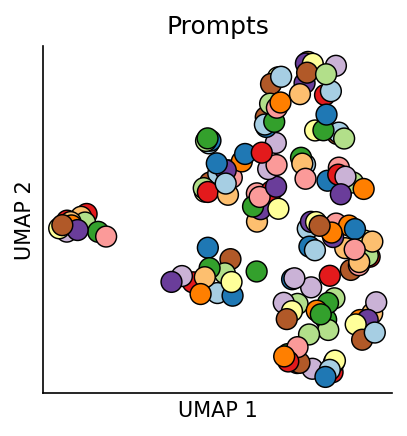

In [12]:
plt.figure(figsize=(3, 3), dpi=150)
sns.scatterplot(data=udf,
                x='UMAP 1',
                y='UMAP 2',
                hue='Prompt',
                palette='Paired',  # Alternative palettes: 'Set2', 'tab10', 'Accent', 'Paired'
                edgecolor='k',  # Set the edge color to black
                s=100,
                legend = False,
                linewidth=0.7)  # Adjust the width of the edge

plt.title('Prompts')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xticks([])
plt.yticks([])
sns.despine()
plt.show()


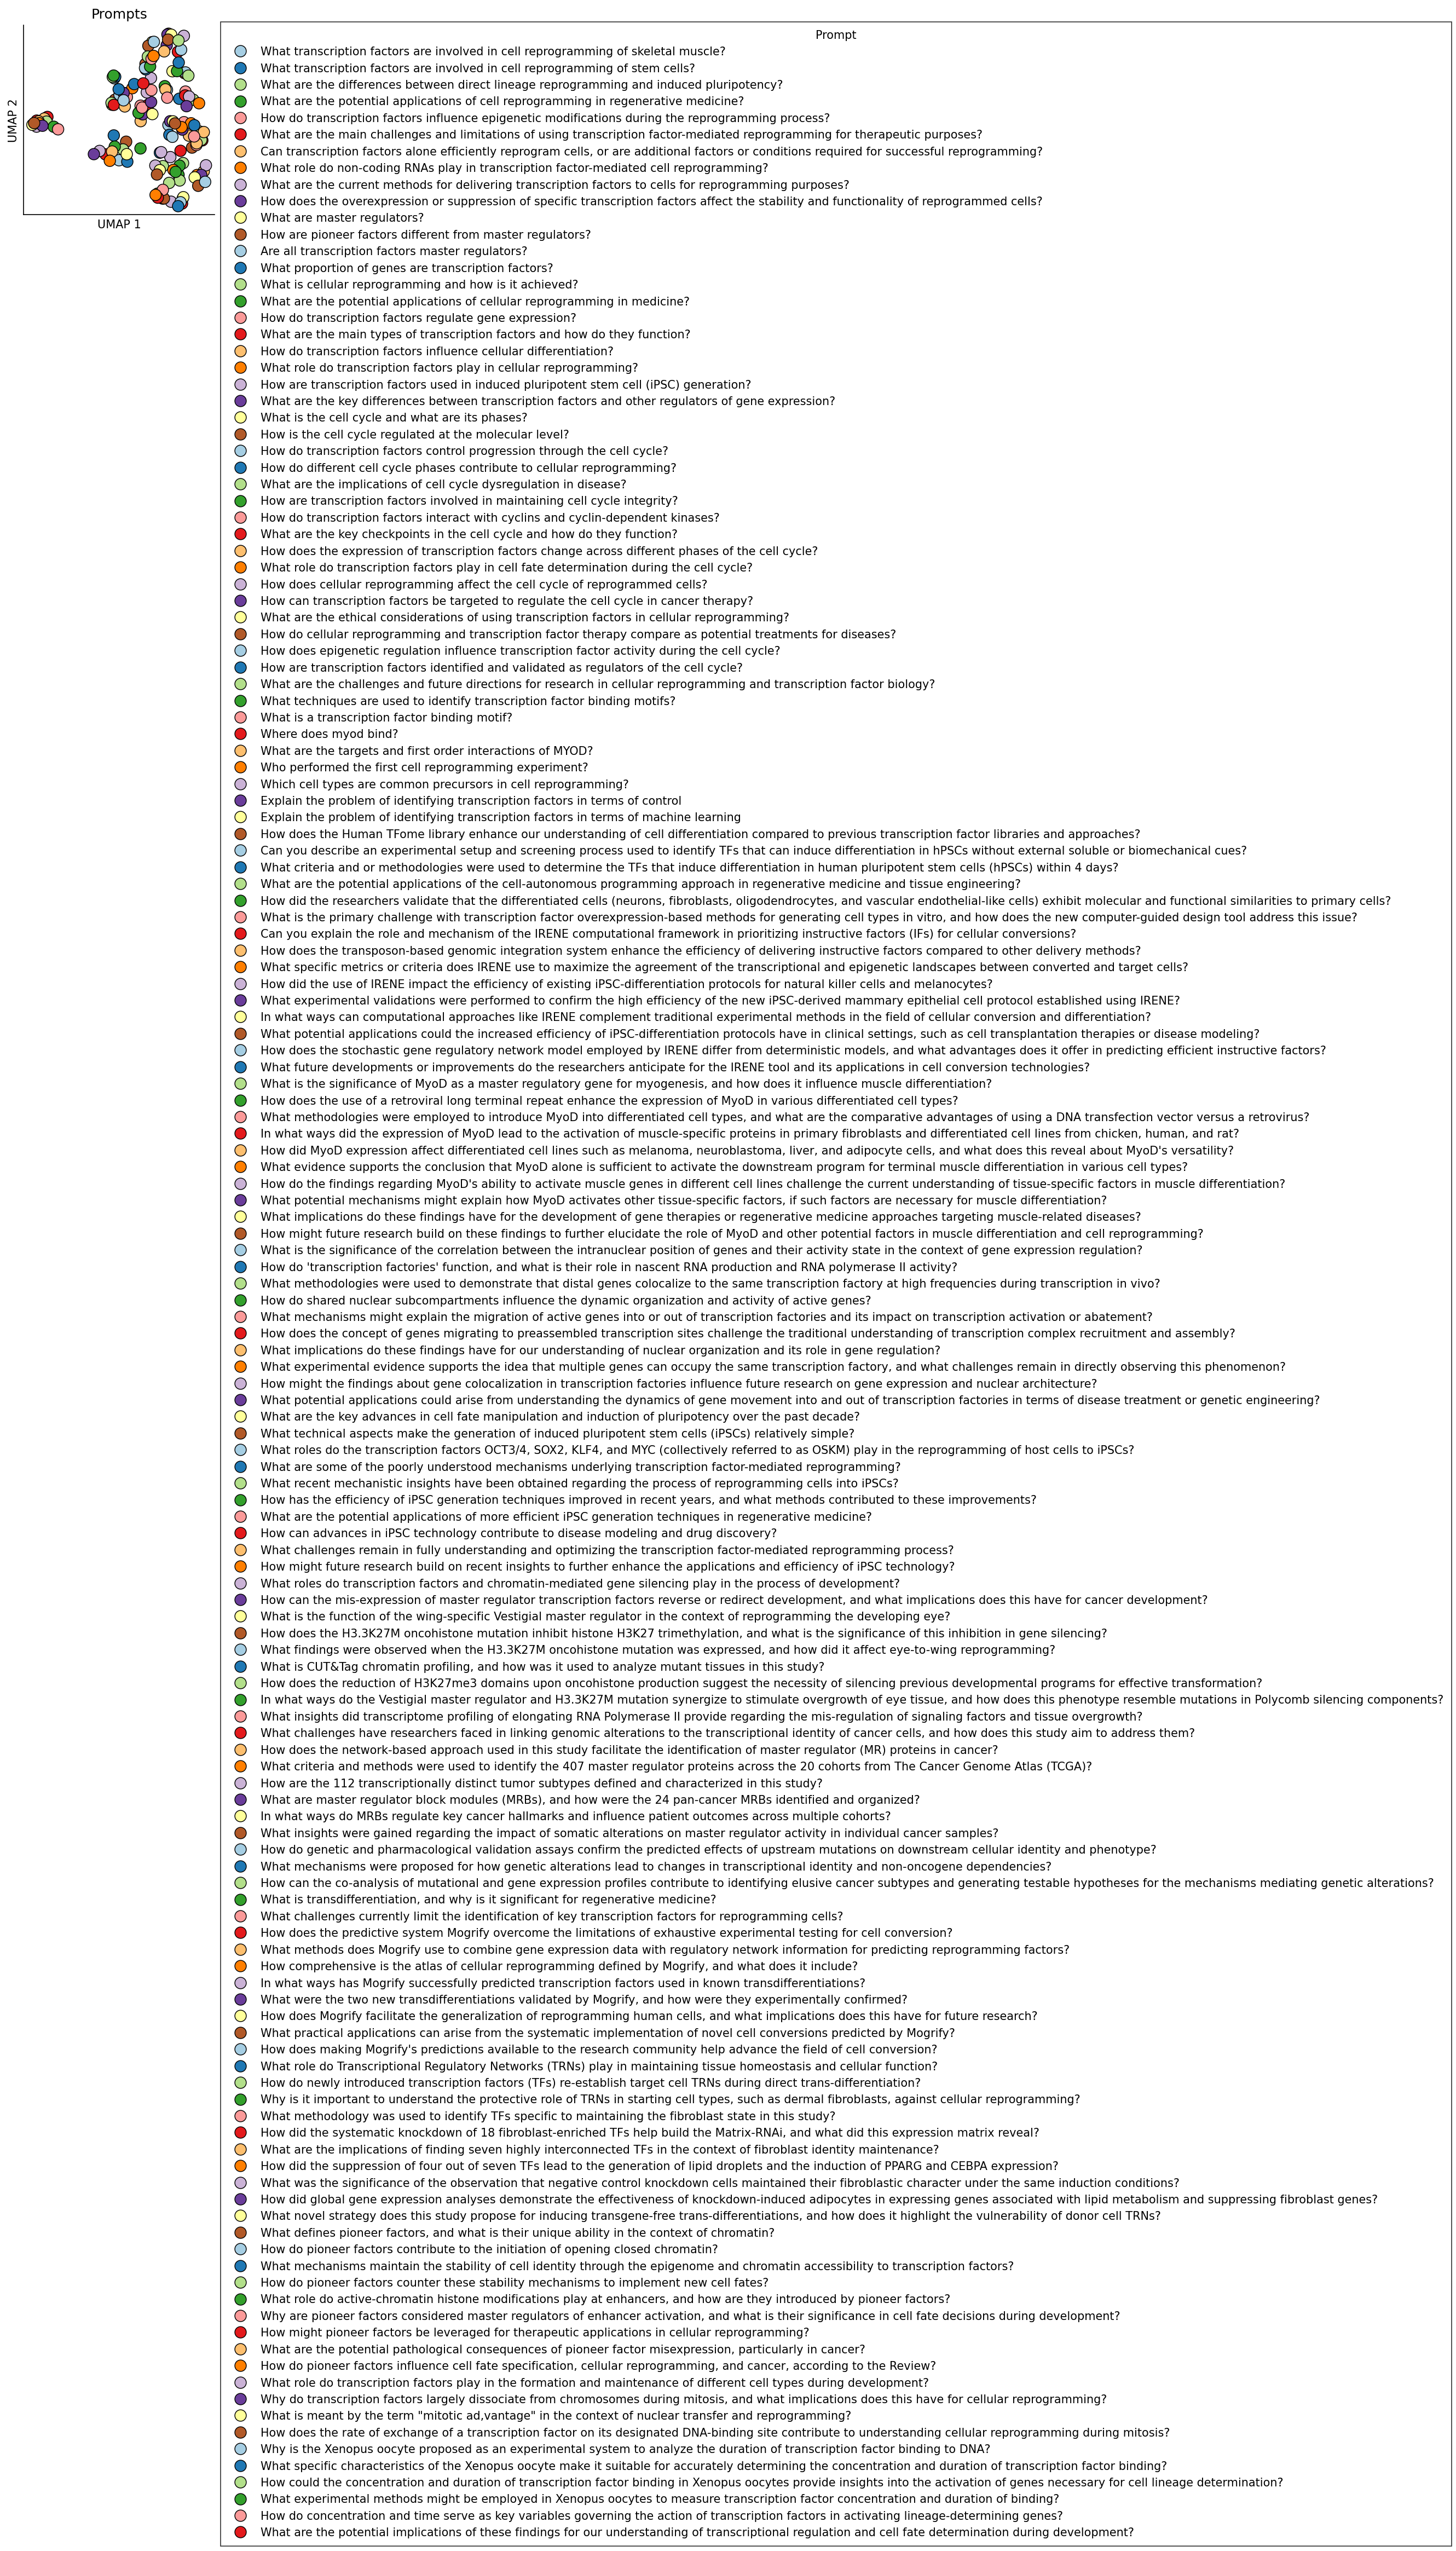

In [13]:
plt.figure(figsize=(3, 3), dpi=150)
sns.scatterplot(data=udf,
                x='UMAP 1',
                y='UMAP 2',
                hue='Prompt',
                palette='Paired',  # Alternative palettes: 'Set2', 'tab10', 'Accent', 'Paired'
                edgecolor='k',  # Set the edge color to black
                s=100,
                linewidth=0.7)  # Adjust the width of the edge

plt.title('Prompts')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xticks([])
plt.yticks([])
legend = plt.legend(title='Prompt', bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., frameon=True)
frame = legend.get_frame()
frame.set_edgecolor('black')  # Set the edge color of the legend
frame.set_boxstyle('Square')  # Set the box style to square
legend.get_frame().set_linewidth(0.8)  # Set the line width of the legend edge
legend.get_frame().set_facecolor('white')  # Set the background color of the legend to white
sns.despine()
plt.show()


### Embed the Documents

In [33]:
embedder = SentenceTransformerEmbeddings(model_name="all-MiniLM-L6-v2")

Sun Jun  9 00:05:28 2024 INFO Use pytorch device_name: cpu
Sun Jun  9 00:05:28 2024 INFO Load pretrained SentenceTransformer: all-MiniLM-L6-v2
/home/jpic/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [29]:
cols = []
for j in range(numDocs):
    cols.append('known' + str(j))
docsDf = df[cols]
uniqueDocs = list(set(docsDf.values.reshape(-1)))
print(len(uniqueDocs))

cols = []
for j in range(numDocs):
    cols.append('knownRef' + str(j))
refsDf = df[cols]
uniqueRefs = []
for k in refsDf.values.reshape(-1):
    uniqueRefs.append(k['source'])
uniqueRefs = list(set(uniqueRefs))
print(len(uniqueRefs))

765
56


In [15]:
embeddings = []
for doc in uniqueDocs:
    embeddings.append(embedder.embed_query(doc))
embeddings = np.array(embeddings)

In [17]:
reducer = umap.UMAP(n_components=2, random_state=0)

embedding = reducer.fit_transform(embeddings)

udf = pd.DataFrame()
udf['UMAP 1'] = embedding[:,0]
udf['UMAP 2'] = embedding[:,1]
udf['Prompt'] = df['prompt']

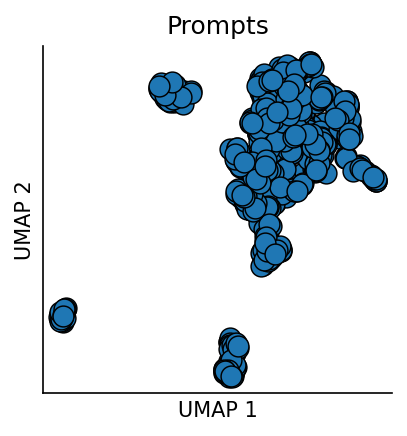

In [18]:
plt.figure(figsize=(3, 3), dpi=150)
sns.scatterplot(data=udf,
                x='UMAP 1',
                y='UMAP 2',
                # hue='Prompt',
                palette='Paired',  # Alternative palettes: 'Set2', 'tab10', 'Accent', 'Paired'
                edgecolor='k',  # Set the edge color to black
                s=100,
                legend = False,
                linewidth=0.7)  # Adjust the width of the edge

plt.title('Prompts')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.xticks([])
plt.yticks([])
sns.despine()
plt.show()


In [54]:
udf.shape

(598, 3)